# Measuring Rust Runtime Performance: cargo bench vs. getrusage()

### TLDR: Comparing cargo bench results to a slightly more robust method eliminates a lot of the noise, but there still appear to be a few performance regressions that both methods agree on. If someone has the statistics expertise to set me straight or help me take this further or both, please get in touch.

* [email](mailto:adam.n.perry@gmail.com)
* [tool used to collect cargo bench results](https://github.com/dikaiosune/secondstring)
* ["tool" used to collect getrusage() results](https://github.com/dikaiosune/rust-runtime-benchmarks/tree/master/bench-suite-linux)
* [repo that has the data files in JSON](https://github.com/dikaiosune/rust-runtime-benchmarks)

Some background: I'm curious about the historical runtime performance of the binaries produced by rustc. About a week ago, [I ran a bunch of benchmarks and made some graphs](https://dikaiosune.github.io/almost-6-months-rust-runtime-perf.html) using `cargo bench` on a few different pinned crate revisions using nightly toolchains from 9/1/15 - 2/11/16. This produced some pretty noisy data, and while it's possible to visually inspect the graphs and find some interesting information, a statistical analysis of performance regressions is pretty difficult. Posting that pseudo-analysis to the Rust subreddit yielded some great feedback, so I thought I'd do it again now that I have more data.

In the GitHub issue that inspired me to try benchmarking historical Rust runtime performance with `cargo bench`, eddyb [made some nice suggestions](https://github.com/rust-lang/rust/issues/31265#issuecomment-185412497) about a benchmark method to reduce the noise in the data that `cargo bench` was producing:

> My 2 cents: don't measure wall-clock time in a multi-threading OS.
On Linux, `getrusage`'s `ru_utime` field will measure time spent in userspace, which helps to remove I/O and scheduling noise. It's not used by `libtest`'s `#[bench]` because it's not portable (AFAIK).

>The ideal solution would involve pinning a single thread to a single core exclusively (i.e. no other threads can run on that core), doing as little I/O as possible, and locking the CPU frequency.

Well, I attempted some of that. There were some other points he made about memory usage, but I haven't even tried to track that yet. The results are mixed. Some not-so-brief observations about this method:

* libc's getrusage() `ru_utime` reports times in increments of 1-4ms on the machines I've tried it on (that is without setting [CONFIG_HIGH_RES_TIMERS and maybe recompiling my kernel](http://man7.org/linux/man-pages/man7/time.7.html)). This meant that I needed to pick a number of iterations for each benchmark that would make sure that 3-4ms represented 1% or less of the total runtime for that benchmark function. I probably could have automated this, but I didn't. Oh well.
* For a few reasons, some of the benchmarks I ported over were not compiling on various nightlies when they'd worked using cargo bench. I opted to remove them from my suite rather than figure the problems out, so the below graphs are only for crates whose benchmarks I ran with both `cargo bench` and the hacked together benchmarks.
* It's pretty easy to make sure that frequency scaling is disabled on my motherboard, and it's also pretty easy to use the [nix crate to set process affinity to a single core](https://github.com/dikaiosune/rust-runtime-benchmarks/blob/master/bench-suite-linux/src/main.rs#L62). It's also pretty easy to [use libc to call getrusage()](https://github.com/dikaiosune/rust-runtime-benchmarks/blob/master/bench-suite-linux/src/bencher.rs#L3) and find time the process has spent in userspace. I am not aware of an easy way to kick all other process off the pinned core. FWIW, I left htop running and any of the 0.1% CPU usage processes which came up from idle appeared to be scheduled on other cores while I was running the benchmark.

So, I wrote a tiny macro to track time used by a given number of iterations, and ported a bunch of crates' benchmark code to use it rather than `libtest` (I will pay my penance to the licensing gods another day). The code (oh, please don't look at it, but if you must) is [available on GitHub](https://github.com/dikaiosune/rust-runtime-benchmarks/tree/master/bench-suite-linux), and the JSON files from both benchmark runs are in the repo root: `example-benchmarks.json` for those using cargo bench, and `getrusage-benchmarks.json` for...you guessed it.

Just like last time, I first took the average runtime for each benchmark function (cargo reports this in nanoseconds/iteration, my suite reports it in microseconds overall) and normalized it against the first point in the relevant series. This produced a number close to 1.0 for each benchmark function, and then for each nightly compiler date, I took the geometric mean to produce a single index value for that crate's benchmark results for that particular nightly compiler. This index is what's plotted below.

Next time: exploring different methods for automating the discovery of knowledge from the large amount of information that these methods produce. First up is the 1st order gaussian derivative. I would be SUPER excited if someone with a more-than-just-googling understanding of time series analysis has some ideas about the most reliable way to process and analyze performance data like this (or memory usage, or cache misses, or whatever else can eventually be benchmarked).

A few notes about what the graphs mean:

* The values are normalized against the measurements from the first point in the series when data was collected. So a value of 1.0 for a benchmark means "approximately the same overall as when we measured in early September 2015."
* The benchmark code that was run at each data point was identical, the only variation was in which compiler and standard library version was used. These were downloaded and run using multirust because I already had it installed.
* No significant processes were used on the desktop where these benchmarks ran. Both benchmark methods were run on the same machine, same kernel version, etc. The machine in question runs Arch Linux. The only significant resource usage was htop.

In [178]:
%matplotlib inline
import datetime
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats.mstats import gmean

matplotlib.style.use('ggplot')
cargo_benches = {}

# process the JSON saved by secondstring
with open('example-benchmarks.json') as m:
    manifest_data = json.loads(''.join(m.readlines()))
    raw_benches = manifest_data['benches']
    for b in raw_benches:
        name = b['name']
        cargo_benches[name] = {}
        results = b['results']
        
        # for successful benchmarks, accumulate a list of all function average times
        for date, r in results.items():
            if r.get('Success', None) is not None:
                bench_run = r['Success']['times']
                for bench_fn in bench_run:
                    if date not in cargo_benches[name]:
                        cargo_benches[name][date] = []
                    
                    time = bench_run[bench_fn]['avg_time_ns']
                    cargo_benches[name][date].append(time)

In [179]:
import statistics as stats
custom_benches = {}

# process the json saved by the custom bench suite
with open('getrusage-benchmarks.json') as f:
    benches = json.loads(''.join(f.readlines()))
    for date, all_benches in benches.items():
        for bench_fn, times in all_benches.items():
            if bench_fn not in custom_benches:
                custom_benches[bench_fn] = {}
                
            if date not in custom_benches[bench_fn]:
                custom_benches[bench_fn][date] = {}
                
            custom_benches[bench_fn][date] = {n: stats.mean(t) for n, t in times.items()}

In [180]:
def normalize_cargo_against_first(bench_results):
    tpls = [(d, avgs) for d, avgs in bench_results.items()]
    tpls = sorted(tpls)
    first = tpls[0]
    
    normalized = {}
    for date, avgs in bench_results.items():
        normalized[date] = [a / f for a, f in zip(avgs, first[1])]
    
    return normalized

In [181]:
def normalize_custom_against_first(bench_results):
    tpls = [(d, avgs) for d, avgs in bench_results.items()]
    tpls = sorted(tpls)
    first = tpls[0]
    
    normalized = {}
    for date, avgs in bench_results.items():
        normalized[date] = []
        for fn in avgs:
            normalized[date].append(avgs[fn] / first[1][fn])
    return normalized

In [182]:
# prep a pandas dataframe of each benchmark suite
def data_frame_for_benchmark(bench_results, cargo=True):
    # parse the dates and calculate the geometric mean
    if cargo:
        bench_results = normalize_cargo_against_first(bench_results)
    else:
        bench_results = normalize_custom_against_first(bench_results)
    bench_results = {datetime.datetime.strptime(d, '%Y-%m-%d'): np.array(v) for d, v in bench_results.items()}
    bench_results = {d: gmean(times) for d, times in bench_results.items()}
    
    # create a dataframe for plotting
    frame = pd.DataFrame.from_dict(bench_results, orient='index')
    if frame.size > 0:
        # sort by date
        frame = frame.sort_index()
        return frame
    else:
        # handle benchmarks that had all of their functions ignored
        return None

In [183]:
# plot a time series for a given benchmark
def plot_benchmark(cargo_bench_times, custom_bench_times):
    cargo_frame = data_frame_for_benchmark(cargo_bench_times, cargo=True)
    custom_frame = data_frame_for_benchmark(custom_bench_times, cargo=False)
    frame = pd.concat({'cargo bench': cargo_frame, 'getrusage()': custom_frame}, axis=1)
    if frame is not None:
        plt.figure()
        frame.plot(figsize=(15,4))
        plt.ylim([0.8, 1.2])
        start_date = datetime.datetime(2015, 9, 1)
        end_date = datetime.datetime(2016, 2, 11)
        plt.xlim([start_date, end_date])

## cbor

The two benchmark methods agree most of the time, although the disagreement around Christmas 2015 is interesting, as they diverged in opposite directions. It's not even a matter of one holding steady while the other moves. However shortly thereafter both method agree that cbor got about 5% faster across the board in mid-January. There was also a fairly distinct and long-lived performance improvement in early October.

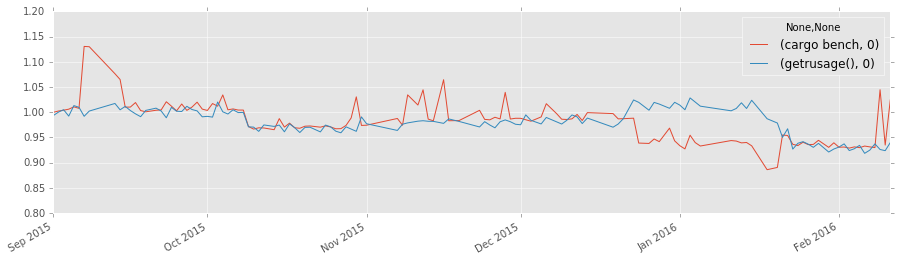

In [184]:
plot_benchmark(cargo_benches['cbor'], custom_benches['cbor'])

## crc

Nothing to see here. Move along.

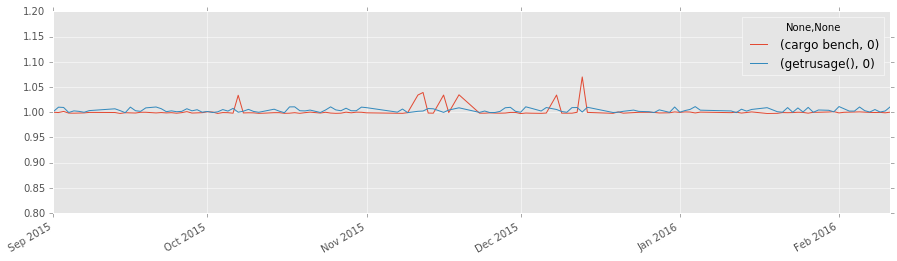

In [185]:
plot_benchmark(cargo_benches['crc'], custom_benches['crc'])

## csv

Both methods seem to agree that csv's performance has been getting ever so slightly slower, up until late January 2016, when it went back to ~1.0.

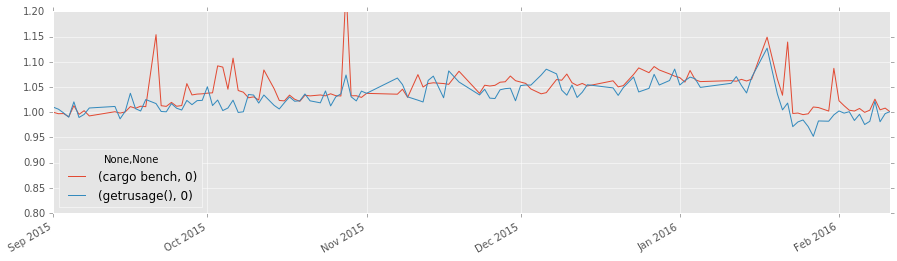

In [186]:
plot_benchmark(cargo_benches['csv'], custom_benches['csv'])

## itertools

While a the noisy portions of the series seems to spend more of its time above 1.0 then below it, there's nothing immediately obvious that I see here.

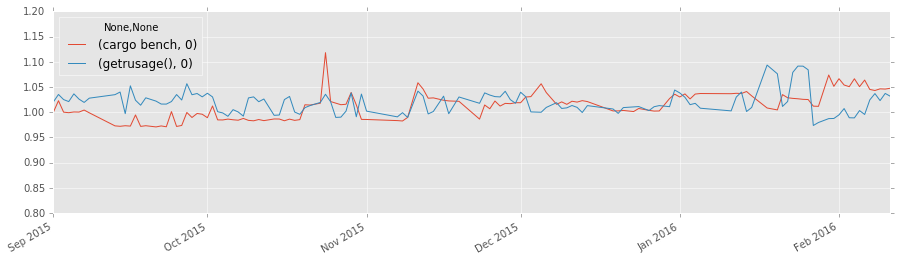

In [187]:
plot_benchmark(cargo_benches['itertools'], custom_benches['itertools'])

## memchr

The method I trust a little more seems to think that memchr had some heft slowdowns in January that is hasn't yet recovered from. That might be an interesting period of time to investigate for a performance regression.

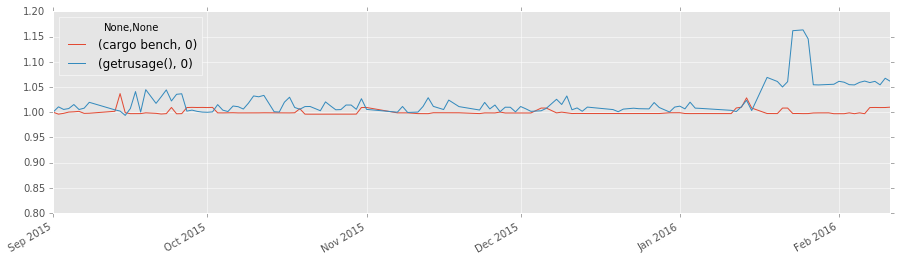

In [188]:
plot_benchmark(cargo_benches['memchr'], custom_benches['memchr'])

## optional

Nothing to see here, move along.

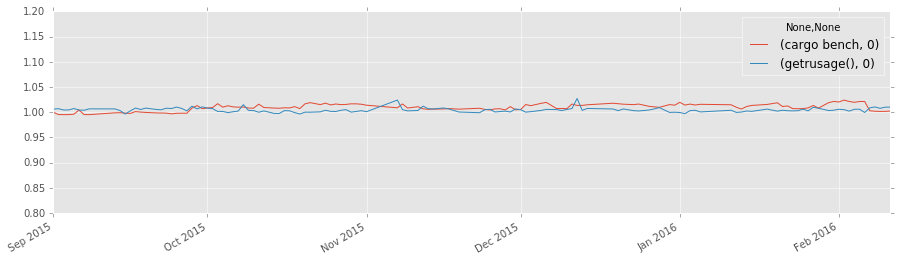

In [189]:
plot_benchmark(cargo_benches['optional'], custom_benches['optional'])

## permutohedron

#### NOTE: The y-axis for this graph is scaled differently than the others due to how far the performance indices moved.

This is the only example I've seen of a really serious performance regression that both benchmark methods agree on. thankfully it appears to be back to normal, but something was causing a ~75% slowdown in permutohedron from mid-September 2015 to late January 2016.

(0.5, 2.5)

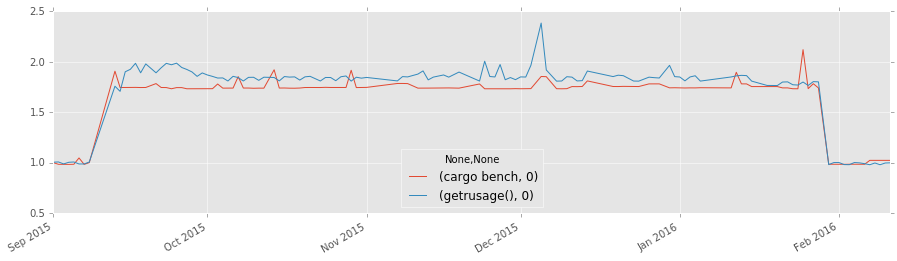

In [190]:
plot_benchmark(cargo_benches['permutohedron'], custom_benches['permutohedron'])
plt.ylim([0.5, 2.5])

## rand

Nothing super interesting here.

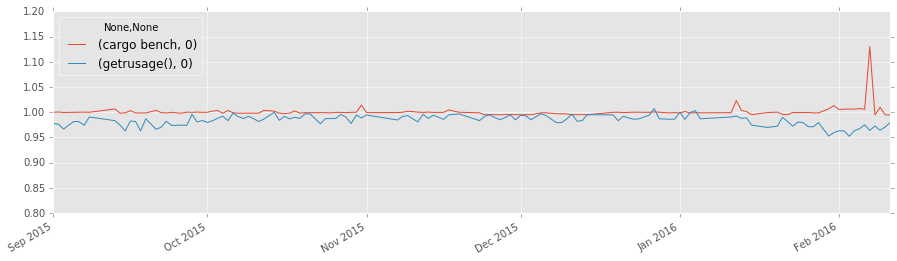

In [191]:
plot_benchmark(cargo_benches['rand'], custom_benches['rand'])

## suffix

The two methods just do not agree at all about suffix's performance, but they seem to agree that something changed in late November 2015, and again in late December, and again in mid-January 2016. Of course, the graph suggests that exactly the opposite thing happened in both of those occasions, which is weird.

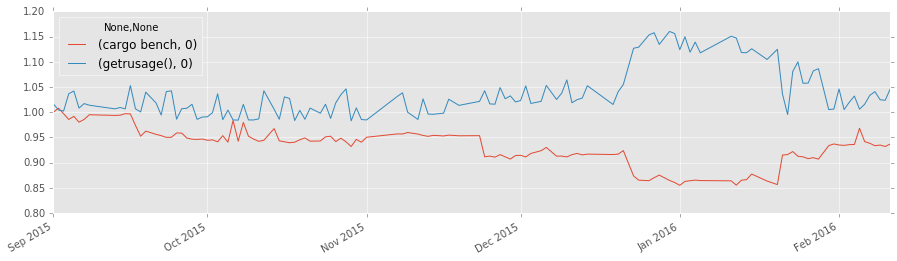

In [192]:
plot_benchmark(cargo_benches['suffix'], custom_benches['suffix'])

## uuid

There's a definite slowdown trend from January 2016 to mid-February 2016 that both methods agree on, even having nearly identical movements on the same days. It looks here like there was a series of successive changes which decreased uuid's runtime performance, but there doesn't appear to be a smoking gun as there is with permutohedron.

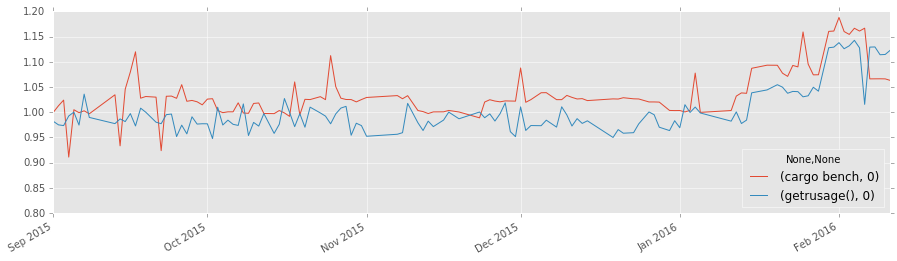

In [193]:
plot_benchmark(cargo_benches['uuid'], custom_benches['uuid'])